In [1]:
import tensorflow as tf

import pandas as pd
pd.set_option('display.max_rows', 10)
import numpy as np
np.set_printoptions(threshold=np.inf) # 数组全部打印出来
import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.datasets import mnist
from keras.utils import to_categorical
import seaborn as sns
%matplotlib inline
import sys, os, time
import matplotlib.pyplot as plt
import scipy.io
# import cv2

import NNbeliefFunc as nnbelief

import sklearn
# roc curve and auc
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix

In [2]:
tf.__version__

'2.3.1'

In [3]:
# os.listdir()

# 加载原始数据集

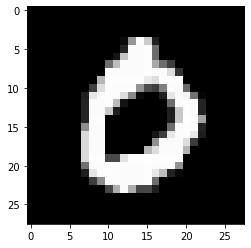

In [4]:
(X_train, Y_train),(X_test, Y_test) = mnist.load_data()
plt.imshow(X_test[3], cmap='gray')
plt.show()

In [5]:
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)) / 255
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)) / 255
X_test.shape
#X_train.shape


(10000, 28, 28, 1)

In [6]:
Y_test.shape

(10000,)

# 加载模型

In [8]:
pre_model = keras.models.load_model('model-lenet5-mnist')
pre_model.trainable = False
pre_model.summary()

Model: "LeNet5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 28, 28, 6)         156       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 14, 14, 6)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 10, 10, 16)        2416      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 120)               48120     
_________________________________________________________________
fc2 (Dense)                  (None, 84)                10164

# 加载fc1与fc2，fc2与output之间的权重和bias

In [10]:
# get the outputs of all layers or a certain layer
# outputs = [rec_model.layers[21].output]   # Output of a certain layer
# 此处层的起始位置要因模型而异
outputs = [layer.output for layer in pre_model.layers[5:]]        # all layer outputs
functor = K.function([pre_model.input],outputs)

In [11]:
#X = X_train
#y = Y_train
X = X_test
Y = Y_test
#获取各层的输出（X：输入样本）
fc_outputs = functor([X])
#提取FC1的输出
fc1_outputs = fc_outputs[0]
#提取FC2的输出
fc2_outputs = fc_outputs[1]
#提取output的输出（预测输出-概率值）
pred_outputs = fc_outputs[2]

In [12]:
# Get the weights and bias of between the last two layers（数组的元素的位置也和模型有关）
#beta_fc1=pre_model.get_weights()[4]  # transposed weights of the 1st hidden layer（flatten—fc1）
#beta_fc2=pre_model.get_weights()[6]   # transposed weights of the 2st hidden layer（fc1—fc2）
beta_output=pre_model.get_weights()[8] # transposed weights of the 3st hidden layer（fc2—output）

#beta_0_fc1=pre_model.get_weights()[5] # bias of the 1st hidden layer（flatten—fc1）
#beta_0_fc2=pre_model.get_weights()[7] # bias of the 1st hidden layer（fc1—fc2）
beta_0_output=pre_model.get_weights()[9] # bias of the 1st hidden layer（fc1—fc2）


In [13]:
beta_0_output

array([-0.00545281,  0.0039664 ,  0.01078585, -0.02290757,  0.00598459,
        0.00209585,  0.00338441, -0.02624411,  0.02546342, -0.00849019],
      dtype=float32)

In [15]:
_beta_0_output =nnbelief.beta_0(beta_0_output)
_beta_0_output

array([-0.00431139,  0.00510782,  0.01192726, -0.02176615,  0.00712601,
        0.00323726,  0.00452582, -0.0251027 ,  0.02660484, -0.00734877],
      dtype=float32)

In [16]:
_beta_output=nnbelief.beta_jk(beta_output)
_beta_output
_beta_output.shape

(84, 10)

In [18]:
_a_output =nnbelief.alpha_jk(_beta_output,_beta_0_output,fc2_outputs)
_a_output
_a_output.shape

(84, 10)

In [19]:
k=nnbelief.conflict(_beta_output,_a_output,fc2_outputs)  #conflict
k

array([2.97385114e-02, 4.85216634e-02, 5.23893163e-02, 1.12775515e-01,
       1.68295513e-01, 2.48174036e-02, 1.30333227e-01, 4.37214743e-01,
       1.53004340e-01, 8.66486991e-02, 5.98910599e-02, 6.24519457e-02,
       6.33038745e-02, 5.23619404e-02, 1.09783456e-01, 1.20075979e-01,
       3.13804950e-02, 3.51960914e-02, 5.32077174e-01, 3.28463036e-02,
       2.64398956e-01, 3.32641540e-01, 4.76992173e-02, 9.84205738e-03,
       8.70505347e-02, 3.40719605e-01, 1.23001879e-01, 3.10996148e-02,
       3.48033560e-02, 1.50437150e-01, 2.91453793e-02, 1.10059815e-01,
       6.46076755e-03, 2.34611622e-01, 1.64776598e-02, 3.58806149e-02,
       2.28530192e-01, 4.84349471e-02, 1.39863479e-01, 5.84295772e-02,
       5.51842155e-01, 3.93993351e-01, 1.31175532e-02, 3.36975453e-01,
       8.47177259e-02, 5.83111554e-02, 4.77616775e-02, 2.37177403e-02,
       2.56919874e-01, 6.00555266e-02, 4.25096673e-02, 1.12536636e-02,
       4.81790533e-03, 1.09387130e-01, 3.46372180e-02, 2.31549634e-02,
      

In [20]:
ig =nnbelief.ignorance(_beta_output,_a_output,fc2_outputs) #ignorance
len(ig)  

10000

In [21]:
a=nnbelief.PowerSetsBinary([4,5,6])  #求子集
a

[[4], [5], [4, 5], [6], [4, 6], [5, 6], [4, 5, 6]]

In [22]:
m_theta_k=nnbelief.m_theta_k(_beta_output,_a_output,fc2_outputs)  #mass
m_theta_k.shape

(10000, 10)

In [23]:
u_set = np.arange(0,_a_output.shape[1])
u_set

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [24]:
C=nnbelief.PowerSetsBinary(u_set)
len(C)

1023

In [136]:
# #计算M([,,……,,])  ##
# m_temp = np.zeros([10000,len(C)])
# for i in range(len(C)):
#     m_temp[:,i]=nnbelief.m_theta_A(_beta_output,_a_output,fc2_outputs,C[i])

In [ ]:
#H_total=nnbelief.H_total(_beta_output,_a_output,fc2_outputs,u_set)


In [25]:
# compare the predicition results using probabilities and mass functions
#概率预测值
pred = []
for i in range(len(pred_outputs)):
    pred.append(np.where(pred_outputs[i]==pred_outputs[i].max())[0][0])
    
#使用mass函数预测的值
pred_nnbelief = []
for i in range(len(pred_outputs)):
    pred_nnbelief.append(np.where(m_theta_k[i]==m_theta_k[i].max())[0][0])

In [26]:
# Accuracy
def acc(pred,label):
    comp = []
    for i in range(len(pred)):
        if(pred[i]==label[i]):
            comp.append(1)
        else:
            comp.append(0)
#     print(sum(comp))
#     print(len(pred))
    return(sum(comp)/len(pred))

# 比较基于概率和mass函数进行预测的准确率
print(acc(pred,Y),acc(pred_nnbelief,Y))

0.9909 0.9909


In [27]:
def precision(x,bit): # 小数点后保留若干位
    temp=[]
    for i in range(len(x)):
        temp.append(format(x[i], bit))
    return(np.array(temp))

a=precision(pred_outputs.max(axis=1),'.4f')
b=precision(m_theta_k.max(axis=1),'.4f')
print(sum(a==b))

9994


In [28]:
# Arrange calculation results in a dataframe
cal_results = pd.DataFrame({'pred.': pred,'pred_nnbelief':pred_nnbelief,'label':Y,'prob.':pred_outputs.max(axis=1),'m_k_max':m_theta_k.max(axis=1), 'conflict': k, 'ignor.': ig})
cal_results = pd.concat([cal_results,pd.DataFrame(m_theta_k)],axis=1)
cal_results.head()
# cal_results.to_csv('cal_rslt/nnbelief_adv_CW.csv', index=False)

,pred.,pred_nnbelief,label,prob.,m_k_max,conflict,ignor.,0,1,2,3,4,5,6,7,8,9
0,7,7,7,0.999927,0.999927,0.029739,2.948158e-51,1.175112e-08,2.124445e-06,5.652121e-06,6.097962e-05,4.117078e-09,3.947603e-08,9.479402e-15,9.999269e-01,1.691510e-07,4.099039e-06
1,2,2,2,0.999916,0.999916,0.048522,3.495753e-50,8.546766e-08,8.072517e-05,9.999158e-01,1.382818e-06,2.620285e-10,4.451960e-11,1.313893e-10,1.205993e-06,7.517243e-07,9.729855e-10
2,1,1,1,0.999918,0.999918,0.052389,1.614606e-42,4.207249e-06,9.999177e-01,2.906490e-06,1.971578e-07,4.596763e-05,3.279387e-07,1.381133e-05,6.147037e-06,2.439725e-06,6.291256e-06
3,0,0,0,0.999613,0.999613,0.112776,2.230466e-42,9.996127e-01,3.012096e-08,1.925894e-05,4.804247e-08,1.209497e-07,2.927994e-06,2.652766e-04,2.225170e-07,9.283228e-06,9.018067e-05
4,4,4,4,0.996340,0.996340,0.168296,1.908426e-45,1.461248e-09,2.047512e-06,1.490334e-09,2.504687e-07,9.963397e-01,7.533989e-08,8.992462e-09,2.163805e-05,1.318628e-07,3.636160e-03


以mass 函数为决策的指标，与probability对比

In [29]:
#cal_results_test = pd.read_csv('calResult/lenet-5/FGSM/nnbelief_test.csv')
cal_results_test = pd.read_csv('calResult/nnbelief_test.csv')
cal_results_H = pd.read_csv('calResult/nnbelief_H_total.csv')
#cal_results_train = pd.read_csv('calResult/nnbelief_train.csv')
cal_results_true_15 = pd.read_csv('calResult/lenet-5/FGSM/nnbelief_adv15.csv')

In [42]:
# plt.rcParams['font.sans-serif']=['SimHei']  #标题识别汉字
# plt.rcParams['axes.unicode_minus'] = False

In [30]:
##计算各类 错误分类和正确分类conflict的均值
def mis_(df):
    mis = []
    tu =[]
    for i in range(10):
        prediction = df[df['label']==i]['pred_nnbelief']
        label = df[df['label']==i]['label']
        c=len(prediction)
        c0=len(label)
        c1=sum(prediction!=label)
        mis.append(df[(df['label']==i)&(df['pred_nnbelief']!=i)]['conflict'].mean())
        tu.append(df[(df['label']==i)&(df['pred_nnbelief']==i)]['conflict'].mean()) 
    return mis,tu

In [31]:
##计算各类 错误分类和正确分类ignore的均值
def mis_1(df):
    mis = []
    tu =[]
    for i in range(10):
        prediction = df[df['label']==i]['pred_nnbelief']
        label = df[df['label']==i]['label']
        c=len(prediction)
        c0=len(label)
        c1=sum(prediction!=label)
        mis.append(df[(df['label']==i)&(df['pred_nnbelief']!=i)]['ignor.'].mean())
        tu.append(df[(df['label']==i)&(df['pred_nnbelief']==i)]['ignor.'].mean()) 
    return mis,tu

In [32]:
mis,tu=mis_(cal_results_test)

mis1,tu1=mis_1(cal_results_test)
np.log(tu1) 
np.log(mis1)

array([ -89.53679357,  -71.25582489,  -87.32838882, -101.02323026,
        -78.47348014,  -75.61322072,  -81.33489958,  -73.92006323,
        -80.83529758,  -69.77457426])

In [46]:
# ###错误分类和正确分类的Hm
# fig, axes = plt.subplots(1,2,figsize=(16,5))
# sns.barplot(np.arange(10),mis,ax=axes[0]) #
# sns.barplot(np.arange(10),tu,ax=axes[1])
# axes[0].set_ylim(0,3)
# axes[0].set_title('Misclasifications Mean H_total per digit')
# axes[1].set_ylim(0,2)
# axes[1].set_title('Correct clasifications Mean m_k_max per digit')

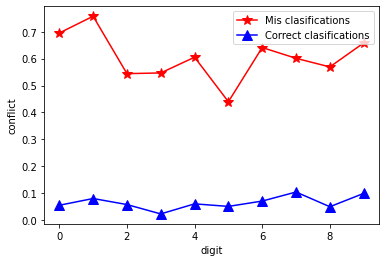

In [34]:
#错误分类和正确分类的conflict   ####可以把accPerNum也放上去
# plt.plot(np.arange(10), mis, "r", marker='*', ms=10, label="错误分类")
# plt.plot(np.arange(10), tu, "b", marker='^', ms=10, label="正确分类")

# plt.legend(loc="upper right")
# plt.title(" 每个类别平均不确定度")
# plt.xlabel('类别')
# plt.ylabel('不确定度')
# plt.show()
###错误分类和正确分类的conflict    ####可以把accPerNum也放上去
plt.plot(np.arange(10), mis, "r", marker='*', ms=10, label="Mis clasifications")
plt.plot(np.arange(10), tu, "b", marker='^', ms=10, label="Correct clasifications")
plt.xlabel('digit')
plt.ylabel('conflict')
plt.legend(loc="upper right")
plt.savefig("Mis-true-k.png",dpi=500)
plt.show()

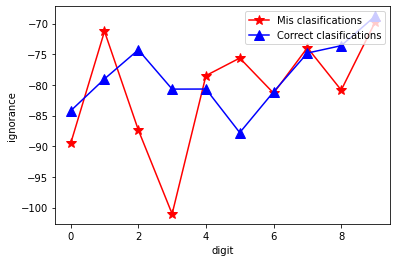

In [35]:
#错误分类和正确分类的ignorance
plt.plot(np.arange(10), np.log(mis1), "r", marker='*', ms=10, label="Mis clasifications")
plt.plot(np.arange(10), np.log(tu1) , "b", marker='^', ms=10, label="Correct clasifications")
plt.xlabel('digit')
plt.ylabel('ignorance')
plt.legend(loc="upper right")
#plt.title(" Mean H_total per digit")

plt.show()

In [37]:
# Calculate the accuracy for each number
def accPerNum(colName,df):
    pr = []
    for i in range(10):
        prediction = df[df['label']==i][colName]
        label = df[df['label']==i]['label']
        pr.append(1-sum(prediction!=label)/len(prediction))
    return pr

# 每个数字的平均冲突值
def meanX(colName,df):
    mean_temp = []
    if(colName=='ignor.'):
        for i in range(10):
            mean_temp.append(np.log(df[df['label']==i][colName]).mean())
    else:
        for i in range(10):
            mean_temp.append(df[df['label']==i][colName].mean())
    return mean_temp


D:\anaconda\envs\tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda\envs\tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda\envs\tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda\envs\tf2\lib\site-package

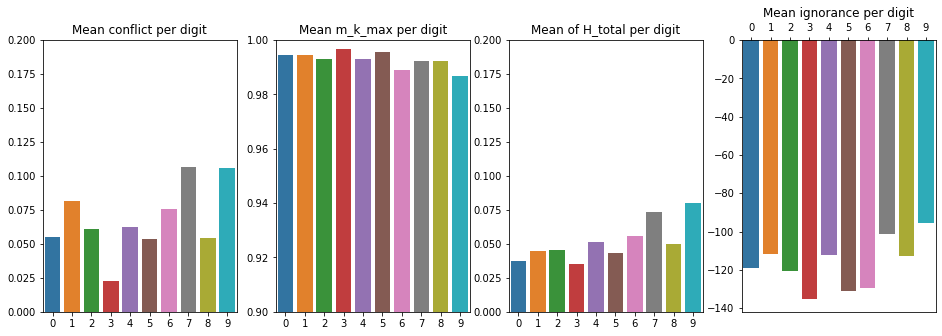

In [38]:
# 每个数字的平均冲突值、平均最大支持度、平均ig、H_total
fig, axes = plt.subplots(1,4,figsize=(16,5))
sns.barplot(np.arange(10),meanX('conflict',cal_results_test),ax=axes[0]) # mean conflict per digit of the test dataset
sns.barplot(np.arange(10),meanX('m_k_max',cal_results_test),ax=axes[1])

sns.barplot(np.arange(10),meanX('H_total',cal_results_H),ax=axes[2]) # mean conflict per digit of the train dataset
sns.barplot(np.arange(10),meanX('ignor.',cal_results_test),ax=axes[3]) # mean ig per digit of the test dataset
#sns.barplot(np.arange(10),meanX('ignor.',cal_results_05),ax=axes[2]) # mean ig per digit of the train dataset
# axes[0].set_ylim(0,1)
axes[0].set_ylim(0,0.2)
axes[0].set_title('Mean conflict per digit')
axes[1].set_ylim(0.90,1)
axes[1].set_title('Mean m_k_max per digit')
axes[2].set_title('Mean of H_total per digit')
axes[2].set_ylim(0,0.2)
axes[3].set_title('Mean ignorance per digit')
axes[3].xaxis.tick_top()

D:\anaconda\envs\tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
D:\anaconda\envs\tf2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


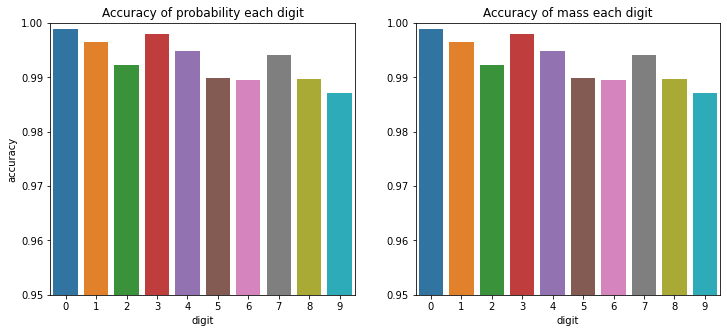

In [39]:
# mass 函数为决策的指标，与probability对比 精确度
pr_ori = accPerNum('pred.',cal_results_test)
pr_01 = accPerNum('pred_nnbelief',cal_results_test)
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.barplot(np.arange(10),pr_ori,ax=axes[0])
sns.barplot(np.arange(10),pr_01,ax=axes[1])
axes[0].set_ylim(0.95,1)
axes[0].set_xlabel('digit')
axes[0].set_ylabel('accuracy')
axes[0].set_title('Accuracy of probability each digit')
axes[1].set_ylim(0.95,1)
axes[1].set_xlabel('digit')
axes[0].set_ylabel('accuracy')
axes[1].set_title('Accuracy of mass each digit')
plt.savefig("M-P.png",dpi=500)
# # mass 函数为决策的指标，与probability对比 精确度
# pr_ori = accPerNum('pred.',cal_results_test)
# pr_01 = accPerNum('pred_nnbelief',cal_results_test)
# fig, axes = plt.subplots(1,2,figsize=(12,5))
# sns.barplot(np.arange(10),pr_ori,ax=axes[0])
# sns.barplot(np.arange(10),pr_01,ax=axes[1])
# axes[0].set_ylim(0.90,1)
# axes[0].set_title('softmax决策的精准率')
# axes[0].set_xlabel('类别')
# axes[0].set_ylabel('精准率')
# axes[1].set_ylim(0.90,1)
# axes[1].set_title('证据分类器的精准率')
# axes[1].set_xlabel('类别')
# axes[1].set_ylabel('精准率')